In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider
import pandas as pd
import sunpy
import sunpy.map
from sunpy.coordinates import (get_earth, get_horizons_coord,
                                Helioprojective, propagate_with_solar_surface,
                                sun)
import astropy
from astropy.coordinates import SkyCoord
from astropy.wcs import WCS
import astropy.units as u
import astropy.constants as const
from astropy.io import fits
from astropy.time import Time
import pfsspy
import pfsspy.tracing as tracing
from reproject import reproject_interp  

import cmcrameri.cm as cmcm
from matplotlib.ticker import (AutoLocator, AutoMinorLocator, 
    FixedLocator, FixedFormatter, LogLocator, StrMethodFormatter)
from astropy.visualization import (AsinhStretch, LinearStretch,
        LogStretch, ImageNormalize)
import os
from sun_blinker import SunBlinker
from copy import deepcopy
from regions import (CircleSkyRegion, Regions)
from fancy_colorbar import plot_colorbar

In [2]:
eis_195_velmap_shift_1024 = sunpy.map.Map("../../src/EIS/DHB_007_v2/20221025T0023/sunpymaps/eis_195_velmap_shift.fits")
eis_195_velmap_shift_1020 = sunpy.map.Map("../../src/EIS/DHB_007_v2/20221020T2343/sunpymaps/eis_195_velmap_shift.fits")

In [3]:
eis_east_region = Regions.read("../../sav/regions/eis_1024_east_pixel.reg")[0].to_sky(eis_195_velmap_shift_1024.wcs)
eis_west_region = Regions.read("../../sav/regions/eis_1020_west_pixel.reg")[0].to_sky(eis_195_velmap_shift_1020.wcs)

For frame 'heliographic_stonyhurst' the following metadata is missing: hgln_obs,dsun_obs,hglt_obs
For frame 'heliographic_carrington' the following metadata is missing: crlt_obs,crln_obs,dsun_obs
 [sunpy.map.mapbase]
For frame 'heliographic_stonyhurst' the following metadata is missing: hgln_obs,dsun_obs,hglt_obs
For frame 'heliographic_carrington' the following metadata is missing: crlt_obs,crln_obs,dsun_obs
 [sunpy.map.mapbase]


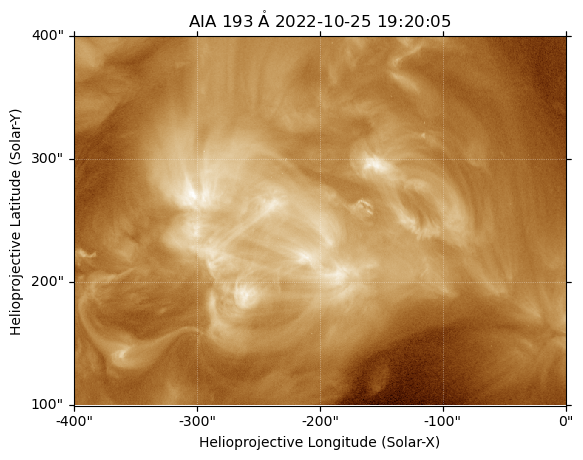

In [4]:
aia_193_map_1025 = sunpy.map.Map("../../src/AIA/20221025/193/lvl15/aia.lev1_euv_12s.2022-10-25T192003Z.193.image.fits")
aia_193_map_1025_crop = aia_193_map_1025.submap(SkyCoord(-400*u.arcsec, 100*u.arcsec,frame=aia_193_map_1025.coordinate_frame),
                                                top_right=SkyCoord(0*u.arcsec, 400*u.arcsec,frame=aia_193_map_1025.coordinate_frame))
aia_193_map_1025_crop.plot()

(-0.5, 666.5, -0.5, 500.5)

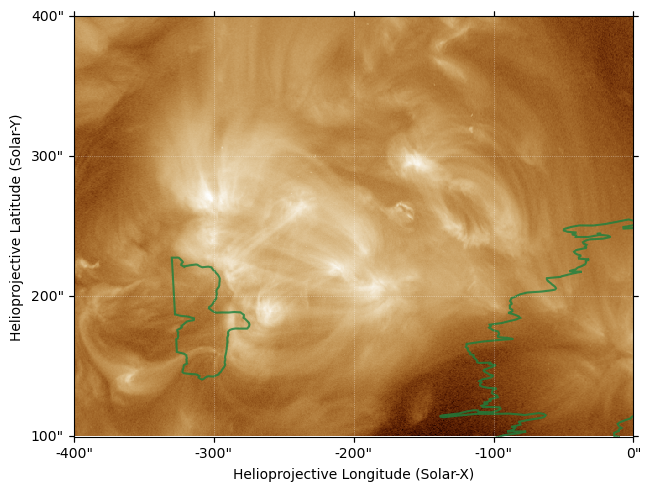

In [5]:
fig = plt.figure(constrained_layout=True)

ax = fig.add_subplot(111, projection=aia_193_map_1025_crop)
aia_193_map_1025_crop.plot(axes=ax, title=False)

bounds = ax.axis()
with propagate_with_solar_surface(rotation_model='rigid'):
    eis_east_region.to_pixel(aia_193_map_1025_crop.wcs).plot(ax=ax, edgecolor='#1B813E', lw=1.5,alpha=0.8)
    eis_west_region.to_pixel(aia_193_map_1025_crop.wcs).plot(ax=ax, edgecolor='#1B813E', lw=1.5,alpha=0.8)
ax.axis(bounds)

In [6]:
# based on mag2pfsspy https://github.com/STBadman/magnetograms2pfsspy/blob/master/mag2pfsspy.py#L12
# written by Samuel Badman, but updated to fit pfsspy 1.2.0
# pfsspy is archived at this moment, but I still use it when the succeeding sunkit-magex is under development
# def extract_br(m):
# 	br = m.data
# 	br = br - np.nanmean(br)
# 	# GONG maps have their LH edge at -180deg, so roll to get it at 0deg
# 	br = np.roll(br, int((m.meta['CRVAL1'] + 180)/np.abs(m.meta['cdelt1'])), axis=1)
# 	br = np.nan_to_num(br)
# 	return br*1e5 # Gauss to nT

def hmi2pfsspy(filepath,rss=2.5,nr=60,ret_magnetogram=False,resample=None, map_type='daily'): 
	if map_type == 'daily':
		hmi_fits_data = fits.getdata(filepath,)
		hmi_fits_header = fits.getheader(filepath,)
		hmi_fits_header['CUNIT2'] = 'Sine Latitude'
		# for card in ['HGLN_OBS','CRDER1','CRDER2','CSYSER1','CSYSER2'] :
		# 	hmi_fits_header[card] = 0

		hmi_fits_header['T_OBS'] = hmi_fits_header['T_OBS'][:-8]+"_TAI"

		hmi_fits_data = np.nan_to_num(hmi_fits_data, nan=0.0)
		# since the cdelt1 is flipped, one should also update the crval1 either through sunpy.L0 (like sam) or manually from FITS header
		# hmi_fits_header['CRVAL1'] = 120 + sun.L0(time=hmi_fits_header['T_OBS']).to_value(u.deg)
		hmi_fits_header['CRVAL1'] = (2262*360*u.deg - (hmi_fits_header["CRVAL1"] + hmi_fits_header["NAXIS1"]*hmi_fits_header["CDELT1"])*u.deg).to_value(u.deg)
		# print(hmi_fits_header['CRVAL1'])

		hmi_map = sunpy.map.sources.HMISynopticMap(hmi_fits_data,hmi_fits_header)
	elif map_type == 'cr':
		hmi_map = sunpy.map.Map(filepath)
		hmi_map = sunpy.map.Map(np.nan_to_num(hmi_map.data, nan=0.0), hmi_map.meta)
		
	if resample is not None: 
		hmi_map = hmi_map.resample(resample)
	
	# br_hmi = extract_br(hmi_map)
	if ret_magnetogram:
		return hmi_map
	pfss_input = pfsspy.Input(hmi_map, nr, rss,)

	pfss_output = pfsspy.pfss(pfss_input)
	return pfss_output

In [8]:
hmi_daily_synoptic_map = hmi2pfsspy("../../src/HMI/CR2263/hmi.Mrdailysynframe_720s.20221025_120000_TAI.data.fits", 
                            resample=[1440,720]*u.pix,ret_magnetogram=True, map_type='daily')

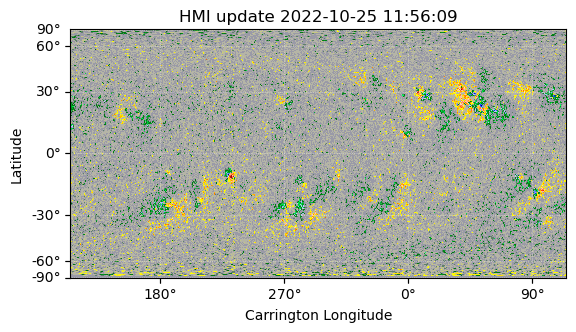

In [9]:
hmi_daily_synoptic_map.plot()

In [10]:
hmi_cr_synoptic_map = hmi2pfsspy("../../src/HMI/CR2263/hmi.synoptic_mr_polfil_720s.2263.Mr_polfil.fits",
                                resample=[1440,720]*u.pix,ret_magnetogram=True, map_type='cr')

INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


For frame 'heliographic_stonyhurst' the following metadata is missing: hgln_obs,dsun_obs,hglt_obs
For frame 'heliographic_carrington' the following metadata is missing: crlt_obs,crln_obs,dsun_obs
 [sunpy.map.mapbase]


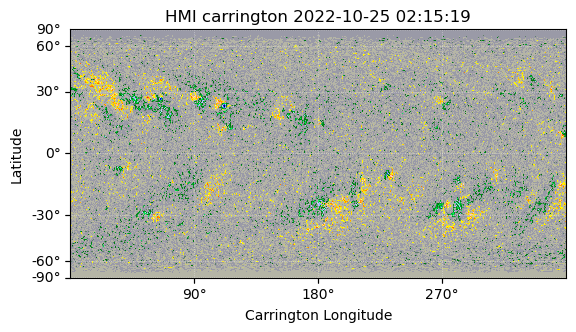

In [11]:
hmi_cr_synoptic_map.plot()

In [12]:
pfss_output = hmi2pfsspy("../../src/HMI/CR2263/hmi.Mrdailysynframe_720s.20221025_120000_TAI.data.fits",
                        resample=[1440,720]*u.pix,nr=60, rss=2.5)

In [13]:
def trace_flines(pfss_output, seed):
    tracer = tracing.FortranTracer()
    with propagate_with_solar_surface():
        flines = tracer.trace(seed, pfss_output)

    return flines

In [24]:
np.rad2deg((np.deg2rad(0.25)*696*u.Mm/const.au.to(u.Mm)).to_value())*3600

4.187225373388955

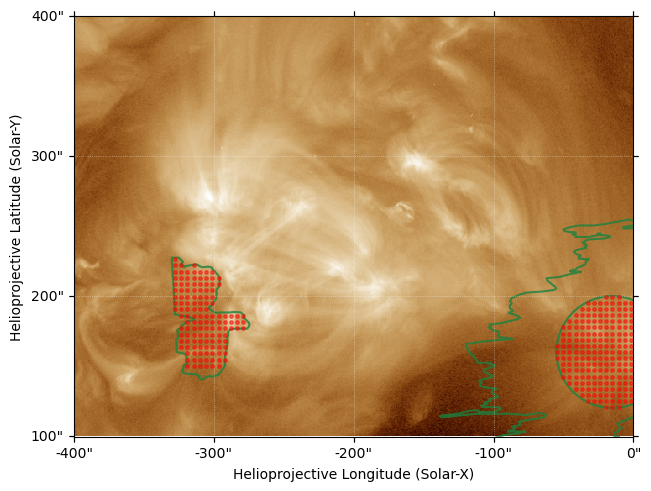

In [25]:
fig = plt.figure(constrained_layout=True)

ax = fig.add_subplot(111, projection=aia_193_map_1025_crop)
aia_193_map_1025_crop.plot(axes=ax, title=False)

bounds = ax.axis()
with propagate_with_solar_surface(rotation_model='rigid'):
    eis_east_region.to_pixel(aia_193_map_1025_crop.wcs).plot(ax=ax, edgecolor='#1B813E', lw=1.5,alpha=0.8)
    eis_west_region.to_pixel(aia_193_map_1025_crop.wcs).plot(ax=ax, edgecolor='#1B813E', lw=1.5,alpha=0.8)
ax.axis(bounds)

seed_east_lon, seed_east_lat = np.meshgrid(np.linspace(-350,-270,19), np.linspace(150,240,21))
seed_east = SkyCoord(seed_east_lon.ravel()*u.arcsec,seed_east_lat.ravel()*u.arcsec,frame=aia_193_map_1025_crop.coordinate_frame)
with propagate_with_solar_surface(rotation_model='rigid'):
    seed_east = seed_east[np.where(eis_east_region.contains(seed_east, aia_193_map_1025_crop.wcs))]
ax.plot_coord(seed_east,marker='.',color='red',markersize=5,alpha=0.5, lw=0)

seed_west_lon, seed_west_lat = np.meshgrid(np.linspace(-54.5,24.5,19), np.linspace(120.5,199.5,19))
seed_west = SkyCoord(seed_west_lon.ravel()*u.arcsec,seed_west_lat.ravel()*u.arcsec,frame=aia_193_map_1025_crop.coordinate_frame)
eis_west_region_circle = CircleSkyRegion(center=SkyCoord(-15*u.arcsec, 160*u.arcsec, frame=aia_193_map_1025_crop.coordinate_frame), radius=40*u.arcsec)
with propagate_with_solar_surface(rotation_model='rigid'):
    eis_west_region_circle.to_pixel(aia_193_map_1025_crop.wcs).plot(ax=ax, edgecolor='#1B813E', lw=1.5,alpha=0.8)
    seed_west = seed_west[np.where(eis_west_region_circle.contains(seed_west, aia_193_map_1025_crop.wcs))]
ax.plot_coord(seed_west,marker='.',color='red',markersize=5,alpha=0.5, lw=0)

In [26]:
# with propagate_with_solar_surface(rotation_model='rigid'):
east_flines = trace_flines(pfss_output, seed_east)
west_flines = trace_flines(pfss_output, seed_west)

/home/yjzhu/anaconda3/envs/sunpy/lib/python3.12/site-packages/pfsspy/output.py:95: UserWarning: Could not parse unit string "Mx/cm^2" as a valid FITS unit.
See https://fits.gsfc.nasa.gov/fits_standard.html for the FITS unit standards.
  warnings.warn(f'Could not parse unit string "{unit_str}" as a valid FITS unit.\n'
/home/yjzhu/anaconda3/envs/sunpy/lib/python3.12/site-packages/pfsspy/tracing.py:180: UserWarning: At least one field line ran out of steps during tracing.
You should probably increase max_steps (currently set to auto) and try again.
  warnings.warn(


In [27]:
def get_loop_length(line):
    c = line.coords.cartesian.xyz
    s = np.append(0., np.linalg.norm(np.diff(c.value, axis=1), axis=0).cumsum()) * c.unit
    return np.diff(s).sum()

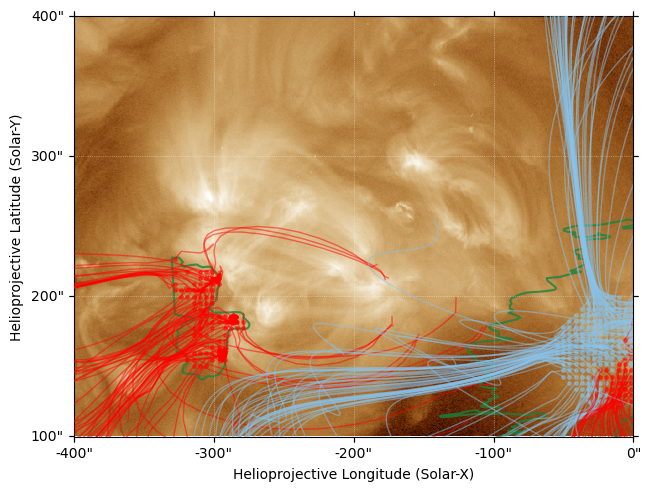

In [32]:
fig = plt.figure(constrained_layout=True)

ax = fig.add_subplot(111, projection=aia_193_map_1025_crop)
aia_193_map_1025_crop.plot(axes=ax, title=False)

bounds = ax.axis()
with propagate_with_solar_surface(rotation_model='rigid'):
    eis_east_region.to_pixel(aia_193_map_1025_crop.wcs).plot(ax=ax, edgecolor='#1B813E', lw=1.5,alpha=0.8)
    eis_west_region.to_pixel(aia_193_map_1025_crop.wcs).plot(ax=ax, edgecolor='#1B813E', lw=1.5,alpha=0.8)
ax.axis(bounds)

with propagate_with_solar_surface():
    for fline, seed in zip(east_flines, seed_east):
        if get_loop_length(fline) > 100 * u.Mm:
            if fline.is_open:
                ax.plot_coord(fline.coords, color='#89c3eb', linewidth=1,alpha=0.5)
                ax.plot_coord(seed, marker='.', color='#89c3eb', markersize=5,alpha=0.5, lw=0)
            else:
                ax.plot_coord(fline.coords, color='red', linewidth=1,alpha=0.5)
                ax.plot_coord(seed, marker='.', color='red', markersize=5,alpha=0.5, lw=0)
    
    for fline, seed in zip(west_flines, seed_west):
        if get_loop_length(fline) > 100 * u.Mm:
            if fline.is_open:
                ax.plot_coord(fline.coords, color='#89c3eb', linewidth=1,alpha=0.5)
                ax.plot_coord(seed, marker='.', color='#89c3eb', markersize=5,alpha=0.5, lw=0)
            else:
                ax.plot_coord(fline.coords, color='red', linewidth=1,alpha=0.5)
                ax.plot_coord(seed, marker='.', color='red', markersize=5,alpha=0.5, lw=0)
        

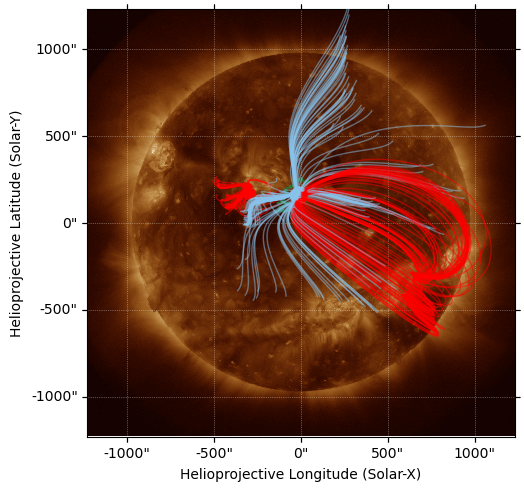

In [29]:
fig = plt.figure(constrained_layout=True)

ax = fig.add_subplot(111, projection=aia_193_map_1025)
aia_193_map_1025.plot(axes=ax, title=False)

bounds = ax.axis()
with propagate_with_solar_surface(rotation_model='rigid'):
    eis_east_region.to_pixel(aia_193_map_1025.wcs).plot(ax=ax, edgecolor='#1B813E', lw=1.5,alpha=0.8)
    eis_west_region.to_pixel(aia_193_map_1025.wcs).plot(ax=ax, edgecolor='#1B813E', lw=1.5,alpha=0.8)
ax.axis(bounds)

with propagate_with_solar_surface():
    for fline, seed in zip(east_flines, seed_east):
        if get_loop_length(fline) > 100 * u.Mm:
            if fline.is_open:
                ax.plot_coord(fline.coords, color='#89c3eb', linewidth=1,alpha=0.5)
                ax.plot_coord(seed, marker='.', color='#89c3eb', markersize=5,alpha=0.5, lw=0)
            else:
                ax.plot_coord(fline.coords, color='red', linewidth=1,alpha=0.5)
                ax.plot_coord(seed, marker='.', color='red', markersize=5,alpha=0.5, lw=0)
    
    for fline, seed in zip(west_flines, seed_west):
        if get_loop_length(fline) > 100 * u.Mm:
            if fline.is_open:
                ax.plot_coord(fline.coords, color='#89c3eb', linewidth=1,alpha=0.5)
                ax.plot_coord(seed, marker='.', color='#89c3eb', markersize=5,alpha=0.5, lw=0)
            else:
                ax.plot_coord(fline.coords, color='red', linewidth=1,alpha=0.5)
                ax.plot_coord(seed, marker='.', color='red', markersize=5,alpha=0.5, lw=0)
                


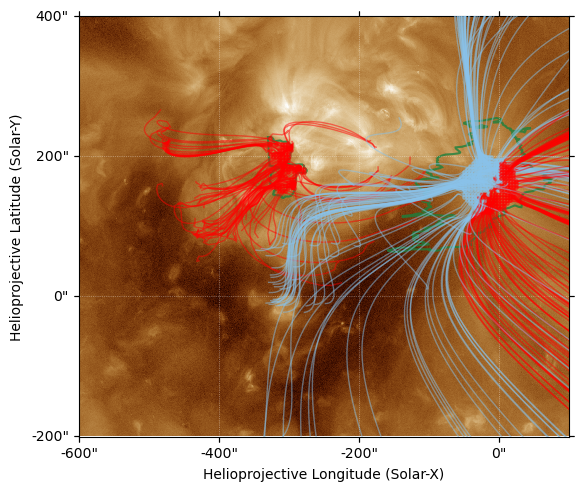

In [34]:
aia_193_map_1025_crop_large = aia_193_map_1025.submap(SkyCoord(-600*u.arcsec, -200*u.arcsec,frame=aia_193_map_1025.coordinate_frame),
                                                top_right=SkyCoord(100*u.arcsec, 400*u.arcsec,frame=aia_193_map_1025.coordinate_frame))

fig = plt.figure(constrained_layout=True)

ax = fig.add_subplot(111, projection=aia_193_map_1025_crop_large)
aia_193_map_1025_crop_large.plot(axes=ax, title=False)

bounds = ax.axis()
with propagate_with_solar_surface(rotation_model='rigid'):
    eis_east_region.to_pixel(aia_193_map_1025_crop_large.wcs).plot(ax=ax, edgecolor='#1B813E', lw=1.5,alpha=0.8)
    eis_west_region.to_pixel(aia_193_map_1025_crop_large.wcs).plot(ax=ax, edgecolor='#1B813E', lw=1.5,alpha=0.8)
ax.axis(bounds)

with propagate_with_solar_surface():
    for fline, seed in zip(east_flines, seed_east):
        if get_loop_length(fline) > 100 * u.Mm:
            if fline.is_open:
                ax.plot_coord(fline.coords, color='#89c3eb', linewidth=1,alpha=0.5)
                ax.plot_coord(seed, marker='.', color='#89c3eb', markersize=5,alpha=0.5, lw=0)
            else:
                ax.plot_coord(fline.coords, color='red', linewidth=1,alpha=0.5)
                ax.plot_coord(seed, marker='.', color='red', markersize=5,alpha=0.5, lw=0)
    
    for fline, seed in zip(west_flines, seed_west):
        if get_loop_length(fline) > 100 * u.Mm:
            if fline.is_open:
                ax.plot_coord(fline.coords, color='#89c3eb', linewidth=1,alpha=0.5)
                ax.plot_coord(seed, marker='.', color='#89c3eb', markersize=5,alpha=0.5, lw=0)
            else:
                ax.plot_coord(fline.coords, color='red', linewidth=1,alpha=0.5)
                ax.plot_coord(seed, marker='.', color='red', markersize=5,alpha=0.5, lw=0)

In [35]:
hri_174_map_shifted_toaia= sunpy.map.Map("../../src/coalign_map/20221025/hri_174_map_shifted_toaia.fits",overwrite=True)

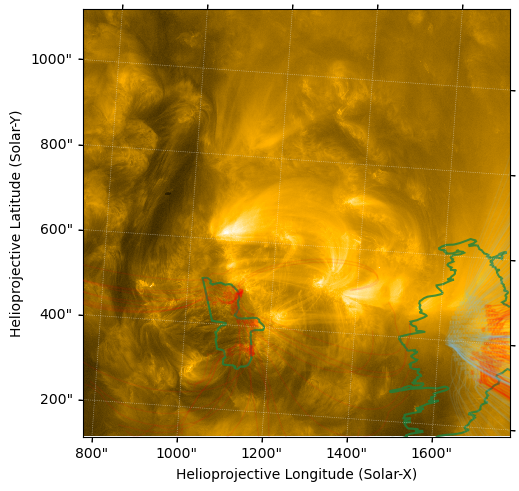

In [42]:
fig = plt.figure(constrained_layout=True)
ax = fig.add_subplot(111, projection=hri_174_map_shifted_toaia)
hri_174_map_shifted_toaia.plot(axes=ax, title=False)

bounds = ax.axis()
with propagate_with_solar_surface(rotation_model='rigid'):
    eis_east_region.to_pixel(hri_174_map_shifted_toaia.wcs).plot(ax=ax, edgecolor='#1B813E', lw=1.5,alpha=0.8)
    eis_west_region.to_pixel(hri_174_map_shifted_toaia.wcs).plot(ax=ax, edgecolor='#1B813E', lw=1.5,alpha=0.8)
ax.axis(bounds)

with propagate_with_solar_surface():
    for fline, seed in zip(east_flines, seed_east):
        if get_loop_length(fline) > 200 * u.Mm:
            if fline.is_open:
                ax.plot_coord(fline.coords, color='#89c3eb', linewidth=1,alpha=0.1)
                ax.plot_coord(seed, marker='.', color='#89c3eb', markersize=5,alpha=0.1, lw=0)
            else:
                ax.plot_coord(fline.coords, color='red', linewidth=1,alpha=0.1)
                ax.plot_coord(seed, marker='.', color='red', markersize=5,alpha=0.1, lw=0)
    
    for fline, seed in zip(west_flines, seed_west):
        if get_loop_length(fline) > 200 * u.Mm:
            if fline.is_open:
                ax.plot_coord(fline.coords, color='#89c3eb', linewidth=1,alpha=0.1)
                ax.plot_coord(seed, marker='.', color='#89c3eb', markersize=5,alpha=0.1, lw=0)
            else:
                ax.plot_coord(fline.coords, color='red', linewidth=1,alpha=0.1)
                ax.plot_coord(seed, marker='.', color='red', markersize=5,alpha=0.1, lw=0)

plt.savefig('../../figs/test_figs/hri_1025_pfss.pdf',dpi=1000,bbox_inches='tight')